# Séance 1 - Réseau dense : Proposition de correction

Ce notebook est une proposition de correction pour le TP de la séance 1. Un travail différent peut être correct sans pour autant être identique à celui-là.

Commençons par importer l'ensemble des éléments dont nous aurons besoin.


In [2]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


mnist = keras.datasets.mnist
(X_train_full, y_train_full), (X_test, y_test) = (mnist.load_data())
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, train_size=0.8)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)
X_valid = scaler.transform(X_valid.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)
X_test = scaler.transform(X_test.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)

11490434/11490434 [==============================] - 1s 0us/step


## Sujet A - Hyper paramètres

L'objectif est de comparer plusieurs réseaux de neurones selon différents hyper paramètres. Pour être le plus efficace possible, nous allons définir une fonction qui prendra en paramètres le learning rate et le nombre d'époques d'entraînement. Cette fonction renverra l'historique d'entraînement pour que l'on puisse en tracer les courbes d'apprentissage.

In [26]:
def design_and_train(learning_rate, n_epochs, verbose=1):
  model = keras.models.Sequential([
      keras.layers.Flatten(input_shape=[28, 28]),
      keras.layers.Dense(256, activation="relu"),
      keras.layers.Dense(128, activation="relu"),
      keras.layers.Dense(10, activation="softmax")
    ])
  model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=learning_rate), metrics=["accuracy"])
  history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=32, validation_data=(X_valid, y_valid), verbose=verbose)
  return history

Commeçons par fixer le nombre d'époques à 75 et observons différentes valeurs de learning rate.
On s'attends à ce que des learning rates faibles convergent lentement vers la solution, mais théoriquement vers un *meilleur* minimum que les learning rate plus élevé.

In [27]:
n_epochs = 75
learning_rates = [10**(-power) for power in range(1, 5)]

results = []
for learning_rate in learning_rates:
  print("Learning rate: %f - époques: %d" % (learning_rate, n_epochs))
  history = design_and_train(learning_rate=learning_rate, n_epochs=n_epochs, verbose=0)
  result = {"learning_rate": learning_rate, "n_epochs": n_epochs, "history": pd.DataFrame(history.history)}
  results.append(result)

Learning rate: 0.100000 - époques: 75
Learning rate: 0.010000 - époques: 75
Learning rate: 0.001000 - époques: 75
Learning rate: 0.000100 - époques: 75


Visualisons les résultats et contrôlons si l'intuition était la bonne.

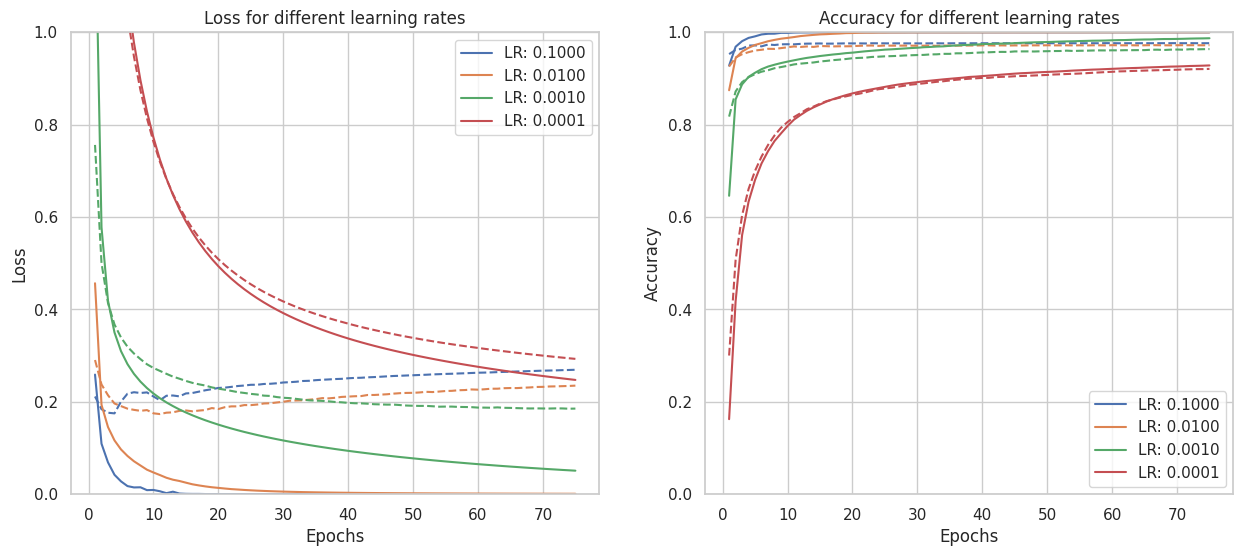

In [28]:
epochs = range(1, n_epochs+1)

figure, (axis_1, axis_2) = plt.subplots(1, 2, figsize=(15, 6))

for index, result in enumerate(results):
  color = sns.color_palette()[index]
  history = result["history"]
  plt.subplot(1, 2, 1)
  axis_1.plot(epochs, history["loss"], label="LR: %0.4f" % result["learning_rate"], color=color)
  axis_1.plot(epochs, history["val_loss"], '--', color=color)

  axis_2.plot(epochs, history["accuracy"], label="LR: %0.4f" % result["learning_rate"], color=color)
  axis_2.plot(epochs, history["val_accuracy"], '--', color=color)

for axis in [axis_1, axis_2]:
  axis.set_ylim(0, 1)
  axis.set_xlabel("Epochs")
  axis.legend()

axis_1.set_ylabel("Loss")
axis_1.set_title("Loss for different learning rates")

axis_2.set_ylabel("Accuracy")
axis_2.set_title("Accuracy for different learning rates")

plt.show()

Il y a deux remarques essentielles:
* Un learning rate fort réduit la loss sur le jeu d'entraînement rapidement, mais exhibe un sur-apprentissage fort. A l'inverse, un learning rate faible converge lentement mais le sur-apprentissage est moins fort
* Un learning rate plus faible semble permettre d'atteindre un minimum sur le jeu de validation plus faible. Nous n'avons pas la fin de la convergence pour le learning rate le plus petit que nous ayons considéré, on ne peut pas être affirmatif sur ce point.

Ces remarques sont identiques pour l'accuracy, et ne sont certaines que pour cette architecture et ce dataset. Cependant, par expérience, ce sont des comportements commun à l'ensemble des réseaux de neurones.
Être capable de trouver la bonne valeur pour le learning rate est crucial pour s'assurer que l'on convergera suffisamment rapidement vers un minimum sans pour autant faire trop de sur-apprentissage.